In [1]:
import jax.numpy as np
import jax.ops
from jax import grad, jit
from functools import partial

In [2]:
data = np.load('data/HOOH.DFT.PBE-TS.light.MD.500K.50k.R_E_F_D_Q.npz')
X = np.array(data['R'][:10])
y = np.array(data['D'][:10])

In [3]:
def fill_diagonal(a, value):
    return jax.ops.index_update(a, np.diag_indices(a.shape[0]), value)

def descriptor(x):
    distances = np.sum((x[:, None] - x[None, :])**2, axis=-1)
    distances = fill_diagonal(distances, 1) # because sqrt fails to compute gradient if called on 0s
    distances = np.sqrt(distances)
    D = 1 / distances
    D = np.tril(D)
    D = fill_diagonal(D, 0)
    return D.flatten()

In [4]:
def gaussian(x, x_, sigma=1):
    d, d_ = descriptor(x), descriptor(x_)
    sq_distance = np.sum((d - d_)**2)
    return np.exp(-sq_distance / sigma)
    

In [5]:
from jax import jacfwd, jacrev
def hessian(f):
    return jacfwd(jacrev(f))

In [6]:
from jax.config import config
config.update("jax_debug_nans", True)

In [7]:
_gaussian = partial(gaussian, X[0])
hess = hessian(_gaussian)
hess(X[1]).shape

(4, 3, 4, 3)

In [8]:
def hess_ij(hess, x):
    H = hess(x)
    K = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            value = np.sum(H[:, i, :, j])
            K = jax.ops.index_update(K, jax.ops.index[i, j], value)
    return K

In [9]:
k = hess_ij(hess, X[1])
k

DeviceArray([[ 5.9604645e-08,  0.0000000e+00,  0.0000000e+00],
             [ 2.9802322e-08, -2.9802322e-08,  0.0000000e+00],
             [-5.9604645e-08, -1.1920929e-07,  2.3841858e-07]],            dtype=float32)

In [10]:
def kernel(x, x_):
    _gaussian = partial(gaussian, x)
    hess = hessian(_gaussian)
    return hess_ij(hess, x_)

In [15]:
def kernel_matrix(X):
    samples = X.shape[0]
    K = np.zeros((samples, samples, 3, 3))
    K = list()
    for i in range(samples):
        K.append(list())
        for j in range(samples):
            # K = jax.ops.index_update(K, jax.ops.index[i, j], kernel(X[i], X[j]))
            K[i].append(kernel(X[i], X[j]))
    K = np.block(K)
    return K

In [16]:
K = kernel_matrix(X)

In [25]:
K

DeviceArray([[ 0.0000000e+00, -2.9802322e-08,  0.0000000e+00,
               5.9604645e-08,  0.0000000e+00,  0.0000000e+00,
               5.9604645e-08,  2.9802322e-08,  0.0000000e+00,
              -1.1920929e-07, -2.9802322e-08, -5.9604645e-08,
               5.9604645e-08,  2.9802322e-08, -1.1920929e-07,
               0.0000000e+00, -2.9802322e-08, -5.9604645e-08,
               5.9604645e-08,  0.0000000e+00,  0.0000000e+00,
              -1.1920929e-07,  5.9604645e-08,  0.0000000e+00,
               0.0000000e+00,  5.9604645e-08,  5.9604645e-08,
              -5.9604645e-08, -5.9604645e-08, -5.9604645e-08],
             [ 0.0000000e+00,  0.0000000e+00, -5.9604645e-08,
               2.9802322e-08, -2.9802322e-08,  0.0000000e+00,
               2.9802322e-08, -2.9802322e-08,  5.9604645e-08,
               0.0000000e+00,  0.0000000e+00, -1.1920929e-07,
              -2.9802322e-08, -1.1920929e-07,  1.1920929e-07,
              -2.9802322e-08, -1.1920929e-07,  5.9604645e-08,
       

In [19]:
%timeit kernel_matrix(X)

12.2 s ± 863 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

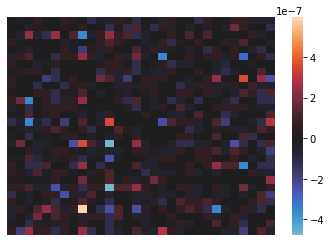

In [24]:
ax = sns.heatmap(K, center=0, xticklabels=False, yticklabels=False)
plt.show()

In [31]:
K = fill_diagonal(K, K.diagonal() + 1e-15)
samples = X.shape[0]
y = y.reshape(samples * 3)
alphas = np.linalg.solve(K, y)
alphas = alphas.reshape(10, 3)

In [35]:
def predict(x):
    mu = np.zeros(3)
    for i in range(samples):
        mu += kernel(x, X[i]) @ alphas[i]
    return mu

In [48]:
y = y.reshape(10, 3)
print(predict(X[9]))
print(y[9])

[ 0.04606414 -0.28939542 -0.55828357]
[ 0.04606372 -0.28939605 -0.5582838 ]
